<a href="https://colab.research.google.com/github/tsussi/Cloud-variability-time-frequency/blob/master/lorenz_rnn_lstm_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Simulate Lorenz ’63

# Lorenz ’63 Attractor & RNN/LSTM Time‐Series Forecasting

**In this notebook you will:**
1. Simulate the Lorenz ’63 dynamical system  
2. Visualize the 3D attractor and the X‐component over time  
3. Prepare data for supervised learning (sequence → next‐step prediction)  
4. Build and train both SimpleRNN and LSTM models in TensorFlow/Keras  
5. Build and train equivalent models in PyTorch  
6. Compare predictive performance (MSE) and plot true vs. predicted trajectories

In [ ]:
import numpy as np                        # numerical operations
from scipy.integrate import odeint         # ODE solver
import matplotlib.pyplot as plt            # plotting
from sklearn.metrics import mean_squared_error  # error metric
from sklearn.model_selection import train_test_split  # data splitting

# Define the Lorenz ’63 system derivatives
def lorenz63(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dx = sigma * (y - x)                  # dx/dt
    dy = x * (rho - z) - y                # dy/dt
    dz = x * y - beta * z                 # dz/dt
    return [dx, dy, dz]

# Simulation parameters
dt = 0.01                                 # time step
t = np.arange(0, 50, dt)                  # time vector from 0 to 50
init_state = [1.0, 1.0, 1.0]              # initial (x,y,z)
data = odeint(lorenz63, init_state, t)    # run the solver to get trajectory

## 2. Plot Lorenz Attractor & X over Time

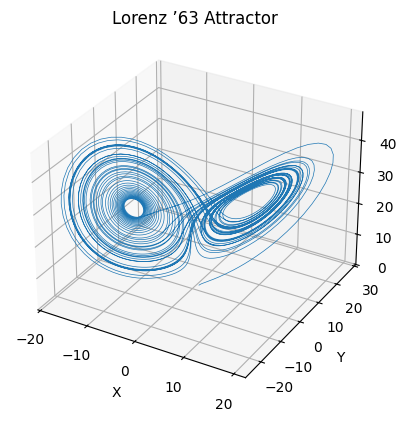

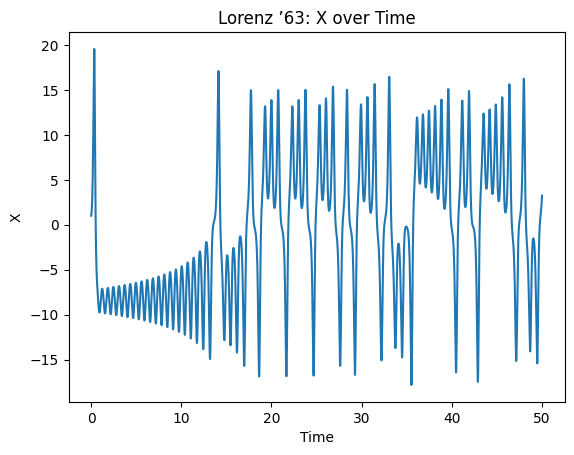

In [ ]:
# 3D phase‐space plot of the Lorenz attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0], data[:,1], data[:,2], lw=0.5)  # plot trajectory in (x,y,z)
ax.set_title("Lorenz ’63 Attractor")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()

# Time‐series of the X‐coordinate
plt.figure()
plt.plot(t, data[:,0])                    # X vs. time
plt.title("Lorenz ’63: X over Time")
plt.xlabel("Time"); plt.ylabel("X")
plt.show()

## 3. Prepare Supervised Learning Sequences
Convert the chaotic trajectory into (sequence → next‐step) pairs.

## 4. Train/Test Split
Use 80% of sequences for training, 20% for testing.

In [ ]:
SEQ_LEN = 10                             # length of input sequences


def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i : i + seq_len])  # sequence of seq_len time‐steps
        y.append(data[i + seq_len])      # target is the following state
    return np.array(X), np.array(y)

X, y = create_sequences(data, SEQ_LEN)   # build arrays of inputs & targets

## 5. TensorFlow / Keras Implementation
Build, compile, and train both SimpleRNN and LSTM models.

In [ ]:
split = int(len(X) * 0.8)                # index of 80% split
X_train, X_test = X[:split], X[split:]   # training & test inputs
y_train, y_test = y[:split], y[split:]   # training & test targets

# Build time vector corresponding to test‐set predictions
t_test = t[SEQ_LEN + split : SEQ_LEN + split + len(y_test)]

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

# Define model input of shape (sequence_length, features=3)
inp = Input(shape=(SEQ_LEN, 3))

# --- SimpleRNN Model ---
x = SimpleRNN(64)(inp)                   # RNN layer with 64 units
out_rnn = Dense(3)(x)                    # Dense head to predict 3 outputs
rnn = Model(inputs=inp, outputs=out_rnn)
rnn.compile(optimizer='adam', loss='mse')
rnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# --- LSTM Model ---
x2 = LSTM(64)(inp)                       # LSTM layer with 64 units
out_lstm = Dense(3)(x2)                  # Dense head for 3‐dim prediction
lstm = Model(inputs=inp, outputs=out_lstm)
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate on test set
rnn_pred = rnn.predict(X_test)           # RNN predictions
lstm_pred = lstm.predict(X_test)         # LSTM predictions
print("Keras SimpleRNN Test MSE:", mean_squared_error(y_test, rnn_pred))
print("Keras LSTM Test MSE:      ", mean_squared_error(y_test, lstm_pred))

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 232.1828 - val_loss: 166.4022
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 143.8536 - val_loss: 119.8840
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 103.1491 - val_loss: 93.3941
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76.2838 - val_loss: 74.6363
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59.8738 - val_loss: 60.2622
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.8439 - val_loss: 48.8965
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 36.9700 - val_loss: 40.0302
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.2615 - val_loss: 33.0280
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.9917 - val_loss: 27.6095
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2405 - val_loss: 23.3043
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3738 - val_loss: 19.7153
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

### 5.1 Plot Keras Predictions vs. True

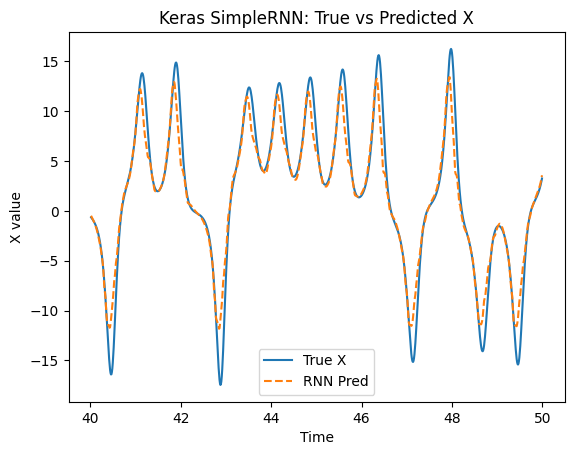

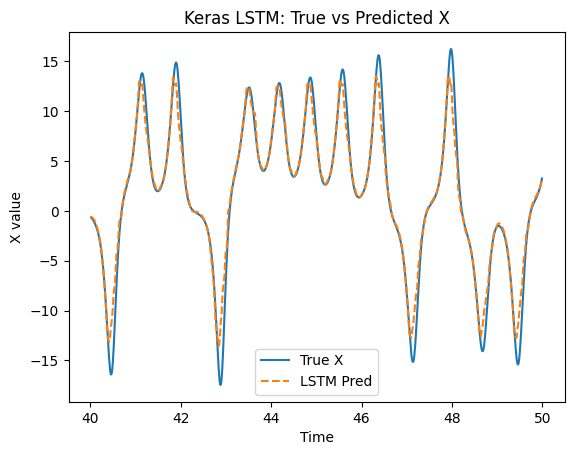

In [ ]:
# Compare true X vs. RNN‐predicted X
plt.figure()
plt.plot(t_test, y_test[:,0], label='True X')
plt.plot(t_test, rnn_pred[:,0], '--', label='RNN Pred')
plt.title("Keras SimpleRNN: True vs Predicted X")
plt.xlabel("Time"); plt.ylabel("X value"); plt.legend()
plt.show()

# Compare true X vs. LSTM‐predicted X
plt.figure()
plt.plot(t_test, y_test[:,0], label='True X')
plt.plot(t_test, lstm_pred[:,0], '--', label='LSTM Pred')
plt.title("Keras LSTM: True vs Predicted X")
plt.xlabel("Time"); plt.ylabel("X value"); plt.legend()
plt.show()

## 6. PyTorch Implementation
Convert data to tensors, define RNN/LSTM classes, train, and evaluate.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
X_tr = torch.tensor(X_train, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.float32)
X_te = torch.tensor(X_test, dtype=torch.float32)
y_te = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=16, shuffle=False)

# Define a simple RNN model class
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])  # use last time‐step

# Define an equivalent LSTM model class
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Instantiate models and optimizers
rnn_model = RNNModel()
lstm_model = LSTMModel()
opt_rnn = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)
opt_lstm = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop function
def train(model, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Train both models
train(rnn_model, opt_rnn)
train(lstm_model, opt_lstm)

# Switch to evaluation mode and predict
rnn_model.eval(); lstm_model.eval()
with torch.no_grad():
    rnn_out = rnn_model(X_te).numpy()   # RNN predictions
    lstm_out = lstm_model(X_te).numpy()  # LSTM predictions

# Print PyTorch test MSE
print("PyTorch RNN Test MSE:", mean_squared_error(y_test, rnn_out))
print("PyTorch LSTM Test MSE:", mean_squared_error(y_test, lstm_out))

PyTorch RNN Test MSE: 0.4090898524685915
PyTorch LSTM Test MSE: 0.1907353306818995


### 6.1 Plot PyTorch Predictions vs. True

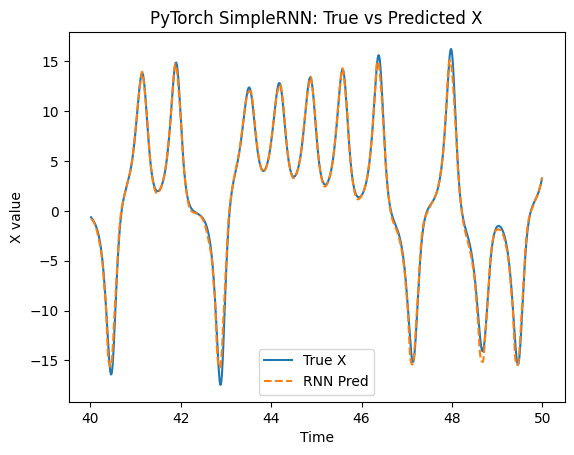

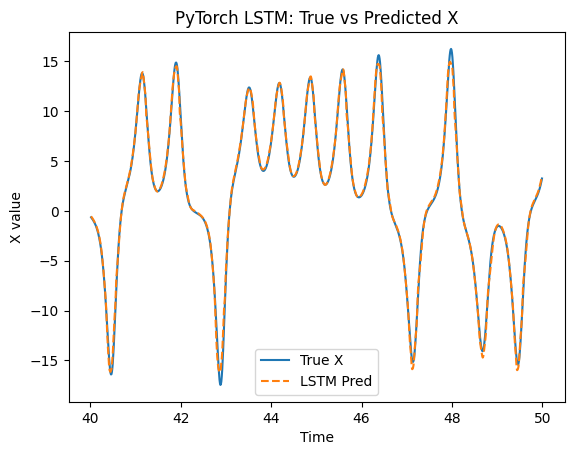

In [ ]:
# True vs. PyTorch RNN prediction for X
plt.figure()
plt.plot(t_test, y_test[:,0], label='True X')
plt.plot(t_test, rnn_out[:,0], '--', label='RNN Pred')
plt.title("PyTorch SimpleRNN: True vs Predicted X")
plt.xlabel("Time"); plt.ylabel("X value"); plt.legend()
plt.show()

# True vs. PyTorch LSTM prediction for X
plt.figure()
plt.plot(t_test, y_test[:,0], label='True X')
plt.plot(t_test, lstm_out[:,0], '--', label='LSTM Pred')
plt.title("PyTorch LSTM: True vs Predicted X")
plt.xlabel("Time"); plt.ylabel("X value"); plt.legend()
plt.show()

## 7. Discussion & Next Steps
- **Model comparison:**  Compare MSE values for each approach.
- **Hyperparameter tuning:**  Experiment with sequence lengths, hidden sizes, learning rates, etc.
- **Multi‐step forecasts:**  Extend to predict several steps ahead recursively.
- **Regularization & dropout:**  Add dropout layers to reduce overfitting on chaotic data.

---
**End of worksheet.**  Feel free to add your own exercises or extension questions below!